In [ ]:
!pip install fsspec --upgrade

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

try:
    from kaggle_datasets import KaggleDatasets
    dataset_gcs = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
    print('got GCS path via KaggleDatasets .get_gcs_path method')
except ModuleNotFoundError:
    #hardcode path while testing locally
    dataset_gcs = 'gs://'


In [2]:
tf.__version__


'2.3.0'

In [3]:
params = {
    'batch_size' : 128,
    'img_size' : [224, 224],
    'epochs': 150
}


In [4]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.126.129.58:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.126.129.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.129.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [5]:
params['batch_size'] = params['batch_size'] * strategy.num_replicas_in_sync

In [6]:
# sub = pd.read_csv(dataset_gcs + '/sample_submission.csv')
# sub.head(1)
!pip install gcsfs

In [7]:
train_df = pd.read_csv(dataset_gcs + '/train.csv')
train_df.groupby('target').count() 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant
target,,,,,,,
0,32542,32542,32477,32474,32024,32542,32542
1,584,584,584,584,575,584,584


In [8]:
def decode_image_label(tfrec):
    '''
    function to decode an image and target label from tfrecord
    
    args:
        tfrec: tfrecord, single record of training/validation data
    
    returns:
        decoded_image: tensor, converted image from tfrecord
        label: tensor, integer, either 1 or 0
    
    '''
    
    features_dictionary = {
        'image': tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
        }
    features = tf.io.parse_single_example(tfrec, features_dictionary)
    decoded_image = tf.io.decode_jpeg(features['image'], 3)
    decoded_image = tf.image.resize(decoded_image, params['img_size'])
    label = features['target']
    
    return decoded_image, label
    


In [9]:
def decode_image(tfrec):
    '''
    function to decode an image from tfrecord
    
    args:
        tfrec: tfrecord, single record of training/validation data
    
    returns:
        decoded_image: tensor, converted image from tfrecord
        img_name: tensor, string, Id of the decoded image
    
    '''
    
    features_dictionary = {
        'image': tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
        }
    features = tf.io.parse_single_example(tfrec, features_dictionary)
    decoded_image = tf.io.decode_jpeg(features['image'], 3)
    decoded_image = tf.image.resize(decoded_image, params['img_size'])
    img_name = features['image_name']
    
    return decoded_image, img_name

In [10]:
def normalize_image_label(decoded_image, label):
    '''
    function to convert an image tensor values from 0 to 255 
    -> -1 to 1
    to be used when dealing with tfrecords containing labels
    
    args:
        decoded_image: tensor that is an image with values from 0 to 255
        label: tensor, target label
    
    returns: 
        image_tensor: tensor that is an image with values from -1 to 1
        label, same as input
    
    '''
    
    #add dim at the zero axis Shape will be from (x, y, z) -> (None, x, y, z)
    image_tensor = tf.expand_dims(decoded_image, 0)
    #undo the above line -- this is needed due to TF not allowing a filtered tensor py_function
    image_tensor = tf.gather(image_tensor, 0)

    #convert tensor values to between -1 and 1 (0 to 255 -> -1 to 1)
    image_tensor = (tf.cast(image_tensor, tf.float32) - 127.5) / 127.5

    return image_tensor, label

In [11]:
def normalize_image(decoded_image):
    '''
    function to convert an image tensor values from 0 to 255 
    -> -1 to 1
    
    args:
        decoded_image: tensor that is an image with values from 0 to 255
    
    returns: 
        image_tensor: tensor that is an image with values from -1 to 1
    
    '''
    
    #add dim at the zero axis Shape will be from (x, y, z) -> (None, x, y, z)
    image_tensor = tf.expand_dims(decoded_image, 0)
    #undo the above line -- this is needed due to TF not allowing a filtered tensor py_function
    image_tensor = tf.gather(image_tensor, 0)

    #convert tensor values to between -1 and 1 (0 to 255 -> -1 to 1)
    image_tensor = (tf.cast(image_tensor, tf.float32) - 127.5) / 127.5

    return image_tensor

In [12]:
def random_flip(image, label):
    '''
    function to randomly flip images on the x and/or y axis
    
    args:
        image: tensor, an image
        label: tensor, target label
    
    returns: 
        image: tensor, same as input, but possibly flipped on x and/or y axis
        label, tensor, same as input
    '''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [13]:
def get_train_ds(tfrecords, batch_size):
    '''
    function to create a ds pipeline from tfrecord files
    
    args:
        tfrecords: list, tfrecord file paths
        batch_size: int, batch size for number of records to pass into
            model at a time
    returns:
        ds: tensorflow input pipeline with images and labels
    '''
    ds = (tf.data.TFRecordDataset(filenames=[tfrecords],
                                 num_parallel_reads=tf.data.experimental.AUTOTUNE).
          cache(). #need to remove cache while not usnig TPUs
          map(decode_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(normalize_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(random_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          repeat().
          shuffle(512).
          batch(batch_size,
               drop_remainder=True).
          prefetch(tf.data.experimental.AUTOTUNE)
         )
    

    
    return ds
    

In [14]:
def get_test_ds(tfrecords, batch_size):
    '''
    function to create a dataset for test data
    args:
        tfrecords: list, tfrecord file paths
        batch_size: int, batch size for number of records to pass into
            model at a time
    returns:
        ds: tensorflow input pipeline with images and labels
    
    '''

    ds = (tf.data.TFRecordDataset(filenames=[tfrecords],
                                 num_parallel_reads=tf.data.experimental.AUTOTUNE).
#           cache(). #there is no reason to cache this ds -- it is only being read 1x
          map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(normalize_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
#           map(random_flip).
          batch(batch_size).
#                 drop_remainder=True).
          prefetch(tf.data.experimental.AUTOTUNE)
         )
    
    return ds
    ###come back to this

# model architecture

In [15]:
def set_of_layers(input_layer, 
                  filters_, 
                  kernal, 
                  strides_, 
                  dense=None, 
                  dense_activation=None,
                  dropout=None,
                  cnn_activation=None):
    '''
    function to add the following layers to a model:
    Conv2D, MaxPooling2D, BatchNormalization, LeadyReLU, Dense,
        Dropout

    args:
      input_layer : input layer to be fed into above layers
      filters_: int, number of filters in Conv2D layer
      kernal: int, kernal size in Conv2D layer
      strides_: int, stride size in MaxPooling2D layer
      dense: int, number of units in dense layer, default is None
          Will only add layer if value is passed
      dense_activation: str, activation function to pass into Dense layer
          default is None
      dropout: float, dropout percentage in Dropout layer, default is None
        must be less than 1.0. Will only add layer if value is passed 
      cnn_activation: tensorflow activation layer, default is None
          will only add layer is value is passed. Activation layer will be
          added after the BatchNormalization layer

    returns:
      x: model that is the same as the input_layer input plus above 
        layers added
        
        
    '''
    x_dict = {}
    for xx in range(len(kernal)):
        x_dict[xx] = layers.Conv2D(filters_, (kernal[xx], kernal[xx]),
                                   padding='same', activation=cnn_activation)(input_layer)
        for _ in range(1): #may be able to try range(2) with the filters halved
            x_dict[xx] = layers.Conv2D(filters_, (kernal[xx], kernal[xx]),
                                       padding='same', activation=cnn_activation)(x_dict[xx])
    x_list = [x_dict[xx] for xx in x_dict]
    if len(x_list) > 1:
        x = layers.Concatenate()(x_list)
    else:
        x = x_list[0]
    x = layers.MaxPooling2D(strides_, strides_)(x)
    x = layers.BatchNormalization()(x)
    

    
    if cnn_activation:
        x = cnn_activation(x)
    x = layers.ReLU()(x)
    if dense:
        x = layers.Dense(dense, activation=dense_activation)(x)
    if dropout:
        x = layers.Dropout(dropout)(x)


    return x

In [16]:
def deconv_set_of_layers(input_layer, 
                         filters_, 
                         kernal_, 
                         stride, 
                         dense=None, 
                         dense_activation=None, 
                         dropout=None,
                         cnn_activation=None):
    '''
    function to add the following layers to a model:
    Conv2DTranspose, BatchNormalization, LeadyReLU, Dense

    args:
      input_layer : input layer to be fed into above layers
      filters_: int, number of filters in Conv2DTranspose layer
      kernal_: int, kernal size in Conv2DTranspose layer
      strides_: int, stride size in Conv2DTranspose layer
      dense: int, number of units in dense layer, default is None
          Will only add layer if value is passed
      dense_activation: str, activation function to pass into Dense layer
          default is None
      dropout: float, dropout percentage in Dropout layer, default is None
        must be less than 1.0. Will only add layer if value is passed 
      cnn_activation: tensorflow activation layer, default is None
          will only add layer is value is passed. Activation layer will be
          added after the BatchNormalization layer


    returns:
      x: model that is the same as the input_layer input plus above 
        layers added
    '''

        
    x_dict = {}
    for xx in range(len(kernal_)):
        x_dict[xx] = layers.Conv2DTranspose(filters_,
                                           kernal_[xx],
                                           (stride, stride),
                                           padding='same')(input_layer)
        x_dict[xx] = layers.BatchNormalization()(x_dict[xx])
    x_list = [x_dict[xx] for xx in x_dict]
    if len(x_list) > 1:
        x = layers.Concatenate()(x_list)
    else:
        x = x_list[0]
    
    if cnn_activation:
        x = cnn_activation(x)
   
    if dense:
        x = layers.Dense(dense, activation=dense_activation)(x)
    
    if dropout:
        x = layers.Dropout(dropout)(x)
    

    return x


In [17]:
def create_model(input_shape=[*params['img_size'], 3], bias_output=None):
    '''
    function to create a model that will be used to train DS via xfer learning
    
    args:
        input_shape: array, default: [1024, 1024, 3], shape
            of input tensor that will be fed into model
    
    returns:
        model: keras.Model() model
    
    '''
    
    input_tensor = layers.Input(shape=input_shape, name='images_input')
    
#     #input s/b 224, 224, 3 // try to normalize 0 -> 1
#     densenet = tf.keras.applications.DenseNet121(include_top=False, 
#                                                  input_shape=input_shape, 
#                                                  classes=1)(input_tensor)
#     end_of_densenet = layers.GlobalAveragePooling2D()(densenet)
#     dense_layers = layers.Dense(512)(end_of_densenet)
#     ###end of densenet### auc - 0.8844 (-1 -> 1)
    
#     #s/b 224, 224, 3 // try to normalize 0 -> 1
#     efficientnet = tf.keras.applications.EfficientNetB0(include_top=False,
#                                                        input_shape=input_shape,
#                                                        classes=1)(input_tensor)
#     end_of_efficientnet = layers.GlobalAveragePooling2D()(efficientnet)
#     dense_layers = layers.Dense(8)(end_of_efficientnet)
#     ###end of efficientnet### auc - 0.8602 (-1 -> 1)
    
    # #s/b 299, 299, 3 // needs to be -1 -> 1
    # inception = tf.keras.applications.InceptionV3(include_top=False,
    #                                              input_shape=input_shape,
    #                                              classes=1)(input_tensor)
    # end_of_inception = layers.GlobalAveragePooling2D()(inception)
    # dense_layers = layers.Dense(8)(end_of_inception)
    # ##end of inception (2016)### auc - 0.9009 (best)
    
#     #s/b 299, 299, 3 // needs to be -1 -> 1
#     inception_v2 = tf.keras.applications.InceptionResNetV2(include_top=False,
#                                                           input_shape=input_shape,
#                                                           classes=1)(input_tensor)
#     end_of_inceptionv2 = layers.GlobalAveragePooling2D()(inception_v2)
#     dense_layers = layers.Dense(8)(end_of_inceptionv2)
#     ###end of inception (2017)###
    
    #s/b 224, 224, 3 // needs to be -1 -> 1
    mobilnet = tf.keras.applications.MobileNet(include_top=False,
                                              input_shape=input_shape,
                                              classes=1)(input_tensor)
    end_of_mobilnet = layers.GlobalAveragePooling2D() (mobilnet)
    dense_layers = layers.Dense(8)(end_of_mobilnet)
    ###end of mobilnet (v1)###

#     # s/b 224, 224, 3 // needs to be -1 --> 1
#     mobilnet_v2 = tf.keras.applications.MobileNetV2(include_top=False,
#                                                    input_shape=input_shape,
#                                                    classes=1)(input_tensor)
#     end_of_mobilnet_v2 = layers.GlobalAveragePooling2D()(mobilnet_v2)
#     dense_layers = layers.Dense(8)(end_of_mobilnet_v2)
#     ###end of mobilnet (2018)###




    



    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
    output = layers.Dense(1, activation='sigmoid', bias_initializer=bias_output)(dense_layers)
    model = keras.Model(inputs=input_tensor, outputs=output)
    
    
    metrics = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = None
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
        metrics=metrics)
    
    
    return model

In [18]:
def create_model_obsol(input_shape=[*params['img_size'], 3], bias_output=None):
    '''
    function to create a model that will be trained on train DS
    
    args:
        input_shape: array, default: [1024, 1024, 3], shape
            of input tensor that will be fed into model
    
    returns:
        model: keras.Model() model
    '''

    relu = layers.ReLU()
    leakyrelu = layers.LeakyReLU()
    input_tensor = layers.Input(shape=input_shape, name='images_input')
    x = input_tensor
#     filters_list = [64, 128, 256, 512, 1024]
    filters_list = [32, 64, 128, 256, 512]
    
    for filter_ in filters_list:
        x = set_of_layers(x, filter_, [3, 5], 2, 16,  dropout=0.35, dense_activation='tanh', 
                           cnn_activation=relu)
        
    
    output_helper_1 = layers.Flatten(name='flatten_output_helper_1')(x)
    output_helper_1 = layers.Dense(128)(output_helper_1)
    
    
    
#     filters_list = [1024, 512, 256]
    filters_list = [512, 256, 128]
    
    for filter_ in filters_list:
        x = deconv_set_of_layers(x, filter_, [2, 4], 2, 16,  dense_activation='tanh', cnn_activation=relu,
                                 dropout=0.35)
    
    output_helper_2 = layers.Flatten(name='flatten_output_helper_2')(x)
    output_helper_2 = layers.Dense(128)(output_helper_2)

    
#     filters_list = [256, 512, 1024]
    filters_list = [128, 256, 512]
    
    for filter_ in filters_list:
        x = set_of_layers(x, filter_, [3, 5], 2, 16,  dropout=0.35, dense_activation='tanh',
                           cnn_activation=relu)



    x = layers.Flatten(name='flatten_main_output')(x)
    x = layers.Dense(128)(x)
#     model.add(layers.Dense(64))
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
    output_layer = layers.Dense(1, activation='sigmoid', bias_initializer=bias_output)(x)
    
    output_helper_1 = layers.Dense(1, activation='sigmoid',
                                  bias_initializer=bias_output)(output_helper_1)
    output_helper_2 = layers.Dense(1, activation='sigmoid',
                                  bias_initializer=bias_output)(output_helper_2)
    
    model=keras.Model(inputs=[input_tensor],
                     outputs=[output_layer, output_helper_1, output_helper_2])

 
           
    metrics = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = None
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.00033),
        loss = [tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
                tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
                tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01)],
        metrics=metrics,
    loss_weights = [1.0, 0.15, 0.15])
    

    
    return model



In [19]:
def get_ds_size(files):
    '''
    function to get size of tfrecord Dataset, based on file name
    
    the file name has the number of records in the file, for example:
    train09-2071.tfrec has 2017 records
    
    args:
        files: list of str file names, each item should be the path to a tfrecord file
    
    returns:
        size: int, size of dataset
    '''
    size = 0
    for file in files:
        file_size = int(file.split('.tfrec')[0].split('tfrecords/')[1].split('-')[1])
        size += file_size
    return size

In [20]:
#get test file paths
test_files = tf.io.gfile.glob(dataset_gcs + '/tfrecords/test*.tfrec')

#get train and validation file paths
train_files, valid_files = train_test_split(tf.io.gfile.glob(dataset_gcs + '/tfrecords/train*.tfrec'),
                              test_size=.1, random_state=1)

#create datasets
train_ds = get_train_ds(train_files, params['batch_size'])
valid_ds = get_train_ds(valid_files, params['batch_size'])
test_ds = get_test_ds(test_files, params['batch_size'])

In [21]:
train_size, valid_size = get_ds_size(train_files), get_ds_size(valid_files)
test_size = get_ds_size(test_files)
print('the dataset consists of: {} training images, {} validation images, and {} test images'.
     format(train_size, valid_size, test_size))

the dataset consists of: 28984 training images, 4142 validation images, and 10982 test images


In [22]:
epoch_steps = train_size / params['batch_size'] 
valid_steps = valid_size / params['batch_size']
test_steps = 1.0 * test_size / params['batch_size'] 

In [23]:
#calculate class weights

targets = train_df.groupby('target').count()['diagnosis'].to_list()
target_0 = targets[0]
target_1 = targets[1]
total = target_0 + target_1

class_weight_0 = (1 / target_0) * (total) / 2.0
class_weight_1 = (1 / target_1) * (total) / 2.0

class_weights = {0: class_weight_0, 1: class_weight_1}

initial_bias = np.log([target_1 / target_0])



In [24]:
def lr_schedule_fn(epoch, lr):
    if epoch < 3:
        return 0.000001
    elif epoch == 3:
        return 0.001
    elif epoch %2 ==0 and epoch < 49:
        return lr * 0.75
    else:
        return lr

In [25]:
with strategy.scope():
    model = create_model(bias_output=initial_bias)
    model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images_input (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 8200      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,237,073
Trainable params: 3,215,185
Non-trainable params: 21,888
_________________________________________________________________


# Training

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', #val_auc
                                patience=25,
                                mode='max',
                                restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule_fn)


history = model.fit(
    train_ds,
#     batch_size=params['batch_size'],
    epochs= params['epochs'], 
    steps_per_epoch=epoch_steps,
    validation_data=valid_ds,
    validation_steps=valid_steps,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_schedule]
)



Epoch 1/150
 2/28 [=>............................] - ETA: 8s - loss: 2.2139 - tp: 0.0000e+00 - fn: 33.0000 - accuracy: 0.9834 - auc: 0.4776WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0044s vs `on_train_batch_end` time: 0.6673s). Check your callbacks.


29/28 [==============================] - ETA: -1s - loss: 2.4052 - tp: 0.0000e+00 - fn: 525.0000 - accuracy: 0.9819 - auc: 0.5009WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0024s vs `on_test_batch_end` time: 0.7698s). Check your callbacks.


29/28 [==============================] - 105s 4s/step - loss: 2.4052 - tp: 0.0000e+00 - fn: 525.0000 - accuracy: 0.9819 - auc: 0.5009 - val_loss: 0.1258 - val_tp: 0.0000e+00 - val_fn: 86.0000 - val_accuracy: 0.9832 - val_auc: 0.4517
Epoch 2/150
29/28 [==============================] - 19s 642ms/step - loss: 2.2919 - tp: 0.0000e+00 - fn: 529.0000 - accuracy: 0.9820 - auc: 0.5352 - val_loss: 0.1293 - val_tp: 0.0000e+00 - val_fn: 87.0000 - val_accuracy: 0.9830 - val_auc: 0.4897
Epoch 3/150
29/28 [==============================] - 19s 669ms/step - loss: 2.1516 - tp: 0.0000e+00 - fn: 525.0000 - accuracy: 0.9819 - auc: 0.5830 - val_loss: 0.1256 - val_tp: 0.0000e+00 - val_fn: 82.0000 - val_accuracy: 0.9840 - val_auc: 0.5258
Epoch 4/150
29/28 [==============================] - 17s 588ms/step - loss: 1.5618 - tp: 434.0000 - fn: 97.0000 - accuracy: 0.5170 - auc: 0.7098 - val_loss: 22.0102 - val_tp: 86.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0168 - val_auc: 0.5000
Epoch 5/150
29/28 [=========

In [27]:
predictions = model.predict(test_ds.map(lambda img, igs: img), steps=test_steps)  

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


In [28]:
prediction_ids = next(iter(test_ds.
                          map(lambda img, ids:ids).
                          unbatch().
                          batch(test_size))).numpy().astype('str')

Cause: could not parse the source code:

                          map(lambda img, ids:ids).

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

                          map(lambda img, ids:ids).

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

                          map(lambda img, ids:ids).

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [29]:
prediction_dict = {
    'image_name': prediction_ids,
    'target': np.concatenate(predictions)
}
submission_ds = pd.DataFrame(prediction_dict)

In [30]:
submission_ds.head()

,image_name,target
0,ISIC_6381819,1.639270e-02
1,ISIC_5583376,5.150219e-03
2,ISIC_6408546,5.357443e-07
3,ISIC_6932354,8.252948e-02
4,ISIC_8191278,1.845418e-03


In [31]:
submission_ds.to_csv('submission.csv', index=False)

# Metrics

In [32]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

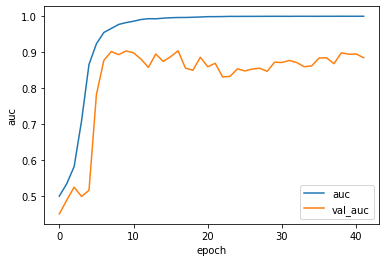

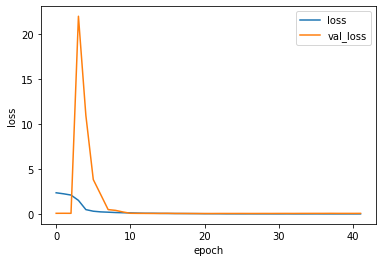

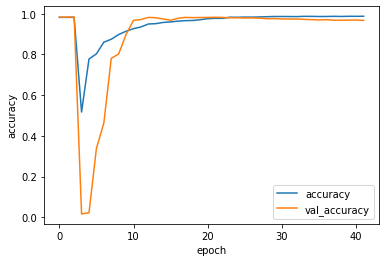

In [33]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [34]:
history.history

{'accuracy': [0.9818830490112305,
  0.9819504022598267,
  0.9819167256355286,
  0.5170393586158752,
  0.7775794863700867,
  0.802734375,
  0.8602842092514038,
  0.874360203742981,
  0.8976966738700867,
  0.9138604402542114,
  0.9265557527542114,
  0.934907078742981,
  0.9494544863700867,
  0.9510371685028076,
  0.9570986032485962,
  0.9594894647598267,
  0.9636651277542114,
  0.9658203125,
  0.9666958451271057,
  0.9705347418785095,
  0.9755859375,
  0.977202296257019,
  0.977168619632721,
  0.982758641242981,
  0.9823545217514038,
  0.9832974076271057,
  0.9831627011299133,
  0.9840719103813171,
  0.9853178858757019,
  0.9862270951271057,
  0.9861934185028076,
  0.985991358757019,
  0.985722005367279,
  0.9870689511299133,
  0.9868668913841248,
  0.9861597418785095,
  0.9863618016242981,
  0.9871363043785095,
  0.9864291548728943,
  0.9873046875,
  0.9870689511299133,
  0.9874730706214905],
 'auc': [0.5009453892707825,
  0.5351574420928955,
  0.5829564332962036,
  0.7098127603530884,


In [ ]:
model.save('model.h5')